In [54]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [55]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
   
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    
   
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs found.")

### Load Datasets 

In [57]:
datasets, datasets_info = tfds.load("malaria",
                                    download=True,
                                    shuffle_files=True,
                                    as_supervised=True,
                                    with_info=True,
                                    data_dir="./data")
datasets_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='./data\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},
      auth

### Data Preprocessing

In [58]:
def split(datasets):
    
    TRAIN_RATIO = 0.8
    VAL_RATIO   = 0.1
    TEST_RATIO  = 0.1

    datasets_size = len(datasets)
    
    train_dataset =  datasets.take(int(datasets_size * TRAIN_RATIO))

    val_test_dataset = datasets.skip(int(datasets_size * TRAIN_RATIO))

    val_dataset =  val_test_dataset.take(int(datasets_size * VAL_RATIO))
    
    test_dataset = val_test_dataset.skip(int(datasets_size * VAL_RATIO))

    return train_dataset,val_dataset,test_dataset

In [59]:
train_dataset,val_dataset,test_dataset = split(datasets["train"])

#### Dataset Visualization

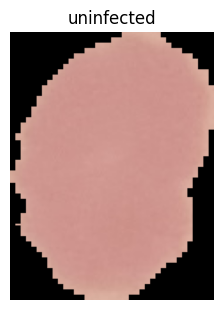

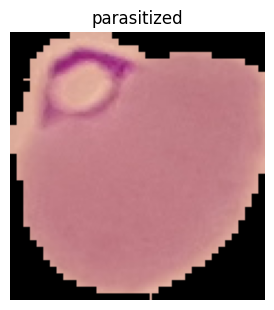

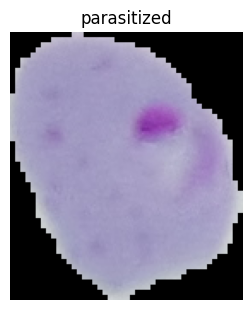

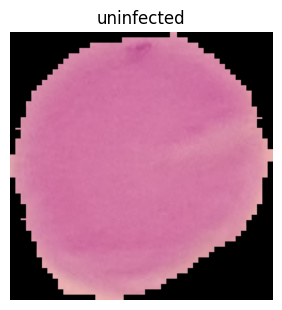

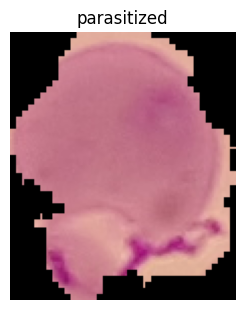

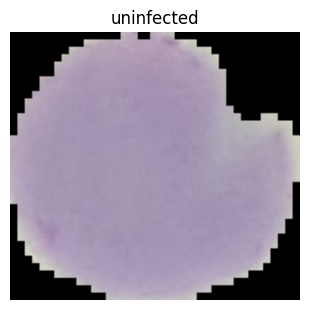

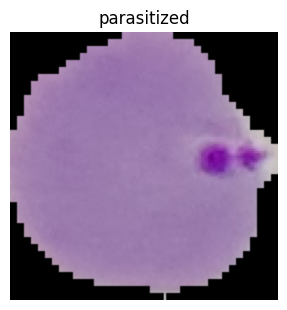

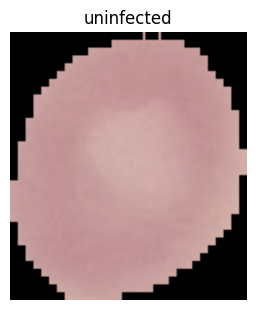

In [60]:
import matplotlib.pyplot as plt




for i, (image, label) in enumerate(train_dataset.take(8)):
    plt.figure(figsize=(20, 16))
    ax = plt.subplot(4, 2, i + 1)
    label_str = datasets_info.features["label"].int2str(label.numpy())  
    ax.set_title(label_str)
    plt.axis("off")
    plt.imshow(image) 

plt.show()


In [61]:
IM_SIZE = 224
def resizing_rescale(image,label):
    return tf.image.resize(image,size=(IM_SIZE,IM_SIZE))/255.0, label

In [62]:
from keras.layers import RandomRotation,RandomFlip,RandomContrast
from keras.layers import Rescaling,Resizing

In [63]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1),
    Resizing(IM_SIZE,IM_SIZE),
    Rescaling(1/255.)

])

In [64]:
def augment_layer(image,label):
    return augment_layers(image),label

In [65]:
test_dataset = test_dataset.map(resizing_rescale)
train_dataset = (train_dataset
    .shuffle(buffer_size=10, reshuffle_each_iteration=True)
    .map(augment_layer)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
    .shuffle(buffer_size=10, reshuffle_each_iteration=True)
    .map(resizing_rescale)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE))


### Model Building

In [66]:
from keras.models import Model
from keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Input, InputLayer, Layer, Dropout
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Recall, Precision, AUC
from keras.optimizers import Adam 
from keras.regularizers import L2

In [67]:
from tensorboard.plugins.hparams import api as hp

In [68]:
hparams = {"HP_DROPOUT":0,
           "HP_REGULARIZATION_RATE":0,
           "HP_NUM_UNITS_1":100,
            "HP_NUM_UNITS_2":10,
            "HP_NUM_FILTER":6,
            "HP_SIZE_KERNEL": 3,
            "HP_SIZE_POOL": 2,
            "HP_NUM_STRIDES":1,
            "HP_LEARNING_RATE": 0.01
           }

In [69]:
class FeatureExtractor(Layer):
    def __init__(self, hparams=hparams, padding="valid", activation="relu", input_shape=(IM_SIZE, IM_SIZE, 3)):
        super(FeatureExtractor, self).__init__()

        self.input_layer = InputLayer(input_shape=input_shape)
        self.conv_1 = Conv2D(hparams["HP_NUM_FILTER"], hparams["HP_SIZE_KERNEL"], hparams["HP_NUM_STRIDES"],
                            padding, activation=activation, kernel_regularizer=L2(hparams["HP_REGULARIZATION_RATE"]))
        self.batch_1 = BatchNormalization()
        self.maxpool_1 = MaxPool2D(hparams["HP_SIZE_POOL"], strides=2 * hparams["HP_NUM_STRIDES"])
        self.dropout_1 = Dropout(hparams["HP_DROPOUT"])

        self.conv_2 = Conv2D(hparams["HP_NUM_FILTER"] * 2, hparams["HP_SIZE_KERNEL"], hparams["HP_NUM_STRIDES"],
                            padding, activation=activation, kernel_regularizer=L2(hparams["HP_REGULARIZATION_RATE"]))
        self.batch_2 = BatchNormalization()
        self.maxpool_2 = MaxPool2D(hparams["HP_SIZE_POOL"], strides=2 * hparams["HP_NUM_STRIDES"])
        self.dropout_2 = Dropout(hparams["HP_DROPOUT"])

        self.conv_3 = Conv2D(hparams["HP_NUM_FILTER"], hparams["HP_SIZE_KERNEL"], hparams["HP_NUM_STRIDES"],
                            padding, activation=activation, kernel_regularizer=L2(hparams["HP_REGULARIZATION_RATE"]))
        self.batch_3 = BatchNormalization()
        self.maxpool_3 = MaxPool2D(hparams["HP_SIZE_POOL"], strides=2 * hparams["HP_NUM_STRIDES"])
        self.dropout_3 = Dropout(hparams["HP_DROPOUT"])


        self.conv_4 = Conv2D(hparams["HP_NUM_FILTER"], hparams["HP_SIZE_KERNEL"], hparams["HP_NUM_STRIDES"],
                            padding, activation=activation, kernel_regularizer=L2(hparams["HP_REGULARIZATION_RATE"]))
        self.batch_4 = BatchNormalization()
        self.maxpool_4 = MaxPool2D(hparams["HP_SIZE_POOL"], strides=2 * hparams["HP_NUM_STRIDES"])
        self.dropout_4 = Dropout(hparams["HP_DROPOUT"])

    def call(self, x, training):
        x = self.input_layer(x)
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.maxpool_1(x)
        x = self.dropout_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.maxpool_2(x)
        x = self.dropout_2(x)

        x = self.conv_3(x)
        x = self.batch_3(x)
        x = self.maxpool_3(x)
        x = self.dropout_3(x)

        x = self.conv_4(x)
        x = self.batch_4(x)
        x = self.maxpool_4(x)
        x = self.dropout_4(x)

        return x


In [70]:
class LenetModel(Model):
    def __init__(self, hparams = hparams):
        super(LenetModel, self).__init__()
        
        
        self.feature_extractor = FeatureExtractor(hparams)
        self.flatten = Flatten()
        self.dense_1 = Dense(hparams["HP_NUM_UNITS_1"], activation="relu",kernel_regularizer=L2(hparams["HP_REGULARIZATION_RATE"]))
        self.batch_1 = BatchNormalization()
        self.dense_2 = Dense(hparams["HP_NUM_UNITS_2"], activation="relu",kernel_regularizer=L2(hparams["HP_REGULARIZATION_RATE"]))
        self.batch_2 = BatchNormalization()
        self.dense_3 = Dense(1, activation="sigmoid")

    def call(self, x, training):

        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)

        return x



lenet_sub_classed_model = LenetModel()

In [71]:
metrics = [TruePositives(name="TP"), FalsePositives(name="FP"), TrueNegatives(name="TN"), FalseNegatives(name="FN"),
           BinaryAccuracy(name="Accuracy"), Precision(name="Precision"), Recall(name="Recall"), AUC(name="AUC")]

Callbacks

In [72]:
from keras.callbacks import EarlyStopping,LearningRateScheduler

In [73]:
es_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,            
    patience=2,           
    verbose=1,               
    mode="auto",             
    baseline=None,         
    restore_best_weights=False )

In [74]:
import math
start_lr = 0.001
exp_decay = 0.1


def scheduler(epoch):
  def lr(epoch, start_lr, exp_decay):
    return start_lr * math.exp(-exp_decay*epoch)
  return lr(epoch, start_lr, exp_decay)

In [75]:
lr_callback = LearningRateScheduler(
    schedule=scheduler,
    verbose=1
)

In [76]:
import datetime

In [77]:
HP_DROPOUT = hp.HParam("dropout_rate", hp.Discrete([0.1, 0.2]))
HP_REGULARIZATION_RATE = hp.HParam("regularization_rate", hp.Discrete([1e-4, 1e-3]))
HP_NUM_UNITS_1 = hp.HParam("num_units_1", hp.Discrete([16, 32]))
HP_NUM_UNITS_2 = hp.HParam("num_units_2", hp.Discrete([16, 32]))
HP_NUM_FILTER = hp.HParam("num_filter_1", hp.Discrete([8, 16]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01]))

In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
                for learning_rate in HP_LEARNING_RATE.domain.values:
                    for filter_size in HP_NUM_FILTER.domain.values:
                            hparams = {
                                "HP_DROPOUT": dropout_rate,
                                "HP_REGULARIZATION_RATE": regularization_rate,
                                "HP_NUM_UNITS_1": num_units_1,
                                "HP_NUM_UNITS_2": num_units_2,
                                "HP_NUM_FILTER": filter_size,
                                "HP_SIZE_KERNEL": 3,
                                "HP_SIZE_POOL": 2,
                                "HP_NUM_STRIDES": 1,
                                "HP_LEARNING_RATE": learning_rate
                            }
                            
                            # Create a new TensorBoard log directory for each run
                            log_dir = "./logs/hparams-" + str(run_number)
                            file_writer = tf.summary.create_file_writer(log_dir)

                            with file_writer.as_default():
                                hp.hparams(hparams)
                                
                                # Create and compile the model
                                model = LenetModel(hparams)
                                model.compile(optimizer=Adam(learning_rate=hparams["HP_LEARNING_RATE"]),
                                              loss=BinaryCrossentropy(),
                                              metrics=["accuracy"])

                                # Train the model
                                history = model.fit(train_dataset,
                                                    validation_data=val_dataset,
                                                    epochs=1,
                                                    verbose=1,
                                                    batch_size=32,
                                                    callbacks=[es_callback,lr_callback])
                                
                                # Log accuracy to TensorBoard
                                tf.summary.scalar("accuracy", history.history['accuracy'][0], step=0)

                            print("For the run {}: Our hparams is {}".format(run_number + 1, hparams))
                            run_number += 1


Tensorboard'dan alınan veriler ile optimum parametreler belirlenir.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs
